In [1]:
import tensorflow as tf
print(tf.__version__)
print("Num of GPUs available: ", len(tf.test.gpu_device_name()))

2022-05-29 03:24:36.318778: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ccao/miniconda3/envs/tf/lib/libcudart.so.11.0
2022-05-29 03:24:36.318791: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2.9.1
Num of GPUs available:  0


2022-05-29 03:24:37.124243: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-29 03:24:37.146368: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-29 03:24:37.146701: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ccao/miniconda3/envs/tf/lib/libcudart.so.11.0
2022-05-29 03:24:37.146736: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

In [7]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam

In [9]:
# load training and testing sets
train_dataset_path = "./monkey/training/training/"
test_dataset_path = "./monkey/validation/validation/"
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train = datagen.flow_from_directory(train_dataset_path, target_size=(160, 160), batch_size=32)
test = datagen.flow_from_directory(test_dataset_path, target_size=(160, 160), batch_size=32, shuffle=False)

FileNotFoundError: [Errno 2] No such file or directory: './monkey/training/training/'

In [5]:
# read labels
file = pd.read_csv('monkey/monkey_labels.txt', sep='[\s,]{2,20}', engine='python')
labels = file['Common Name']
labels

0               mantled_howler
1                 patas_monkey
2                  bald_uakari
3             japanese_macaque
4               pygmy_marmoset
5        white_headed_capuchin
6             silvery_marmoset
7       common_squirrel_monkey
8    black_headed_night_monkey
9               nilgiri_langur
Name: Common Name, dtype: object

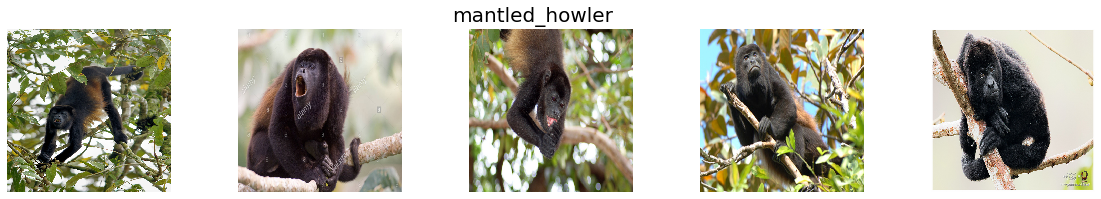

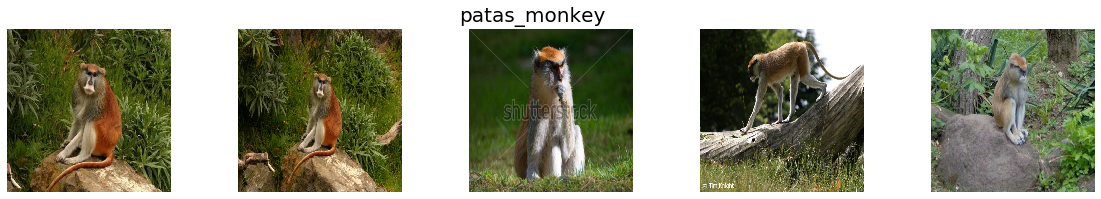

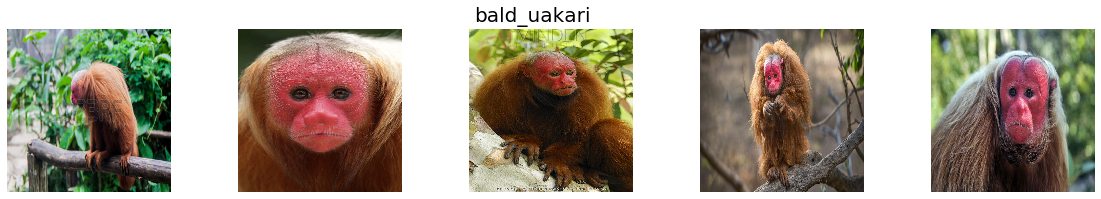

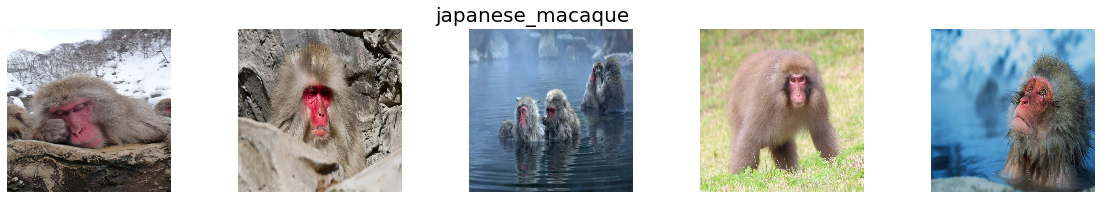

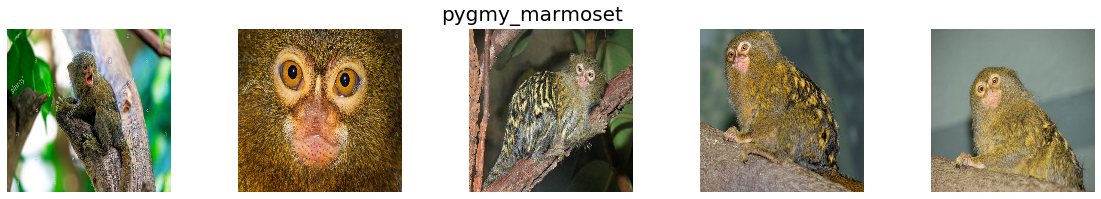

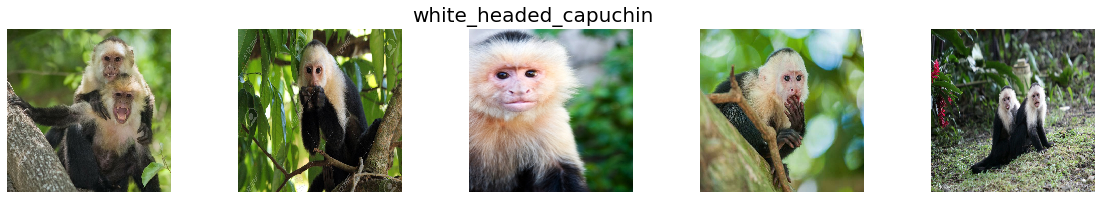

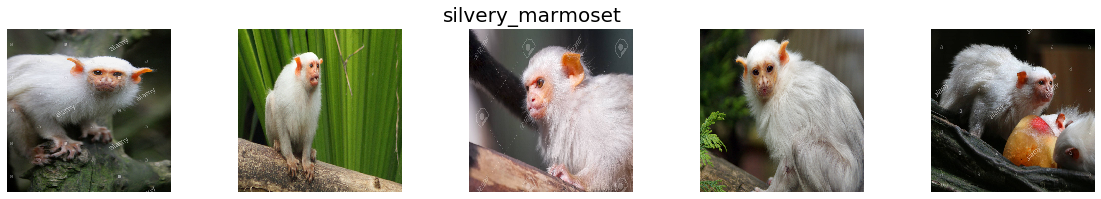

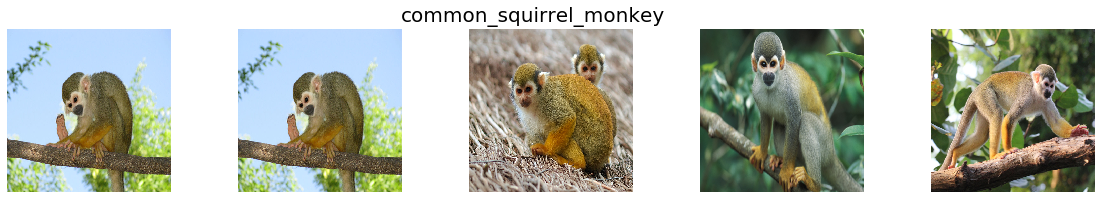

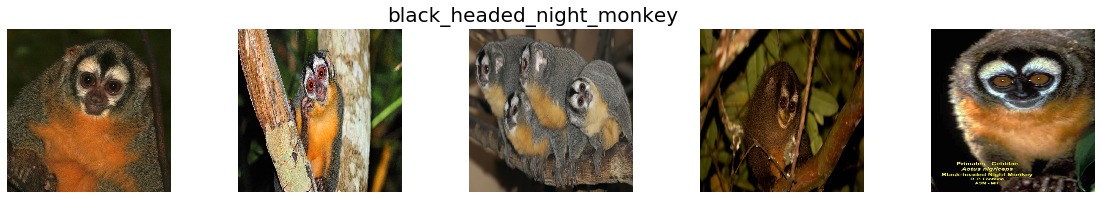

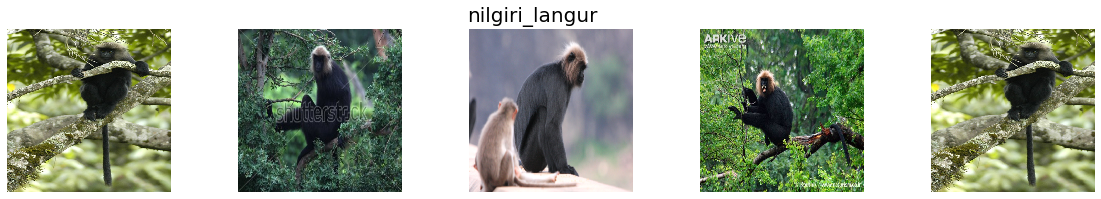

In [6]:
# display images of each category
folders = os.listdir(train_dataset_path)
folders.sort()
for i, folder in enumerate(folders):
    path = train_dataset_path + folder
    imgs = os.listdir(path)
    plt.figure(figsize=(20,3))
    for j in range(5):
        img = cv2.cvtColor(cv2.imread(path + '/' + imgs[j]), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (640, 640))
        plt.subplot(1,5,j+1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(labels[i], fontsize="20")
    plt.show()
    print("\n\n")

In [7]:
IMG_SHAPE = (160, 160, 3)
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=IMG_SHAPE)

Instructions for updating:
Colocations handled automatically by placer.


/opt/conda/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 3s 0us/step


In [8]:
base_model.trainable = False
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(514, activation='relu')(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 160, 160, 3)       0         
_________________________________________________________________
resnet50 (Model)             (None, 5, 5, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_1 (Dense)              (None, 514)               526850    
___________________________

In [9]:
model.compile(optimizer=Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
history = model.fit_generator(train, epochs=5)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
35/35 [==============================] - 28s 794ms/step - loss: 1.0810 - acc: 0.7001
Epoch 2/5
35/35 [==============================] - 29s 826ms/step - loss: 0.1784 - acc: 0.9608
Epoch 3/5
35/35 [==============================] - 29s 815ms/step - loss: 0.0821 - acc: 0.9772
Epoch 4/5
35/35 [==============================] - 28s 805ms/step - loss: 0.0470 - acc: 0.9945
Epoch 5/5
35/35 [==============================] - 28s 806ms/step - loss: 0.0340 - acc: 0.9964


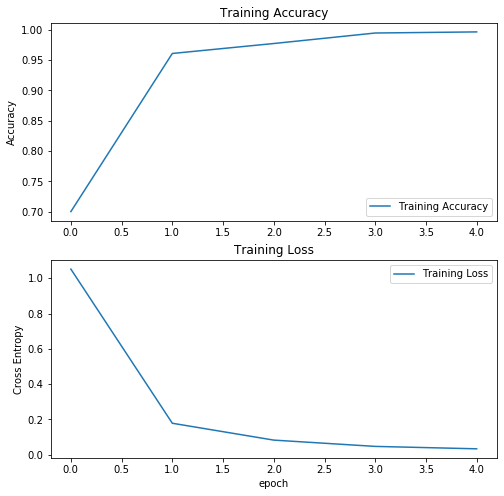

In [11]:
acc = history.history['acc']
loss = history.history['loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
prediction = model.predict_generator(test)
predicted_classes = np.argmax(prediction, axis=1)
test_acc = np.mean(predicted_classes == test.classes)
print("Test accuracy: {:.6f}".format(test_acc))

In [16]:
show_test = ImageDataGenerator().flow_from_directory(test_dataset_path, target_size=(160, 160), batch_size=test.samples, shuffle=False)
x, _ = show_test.next()
classes = test.classes

Found 272 images belonging to 10 classes.


In [17]:
# generate random indices
random_indices = np.random.randint(0, test.samples, size=28)

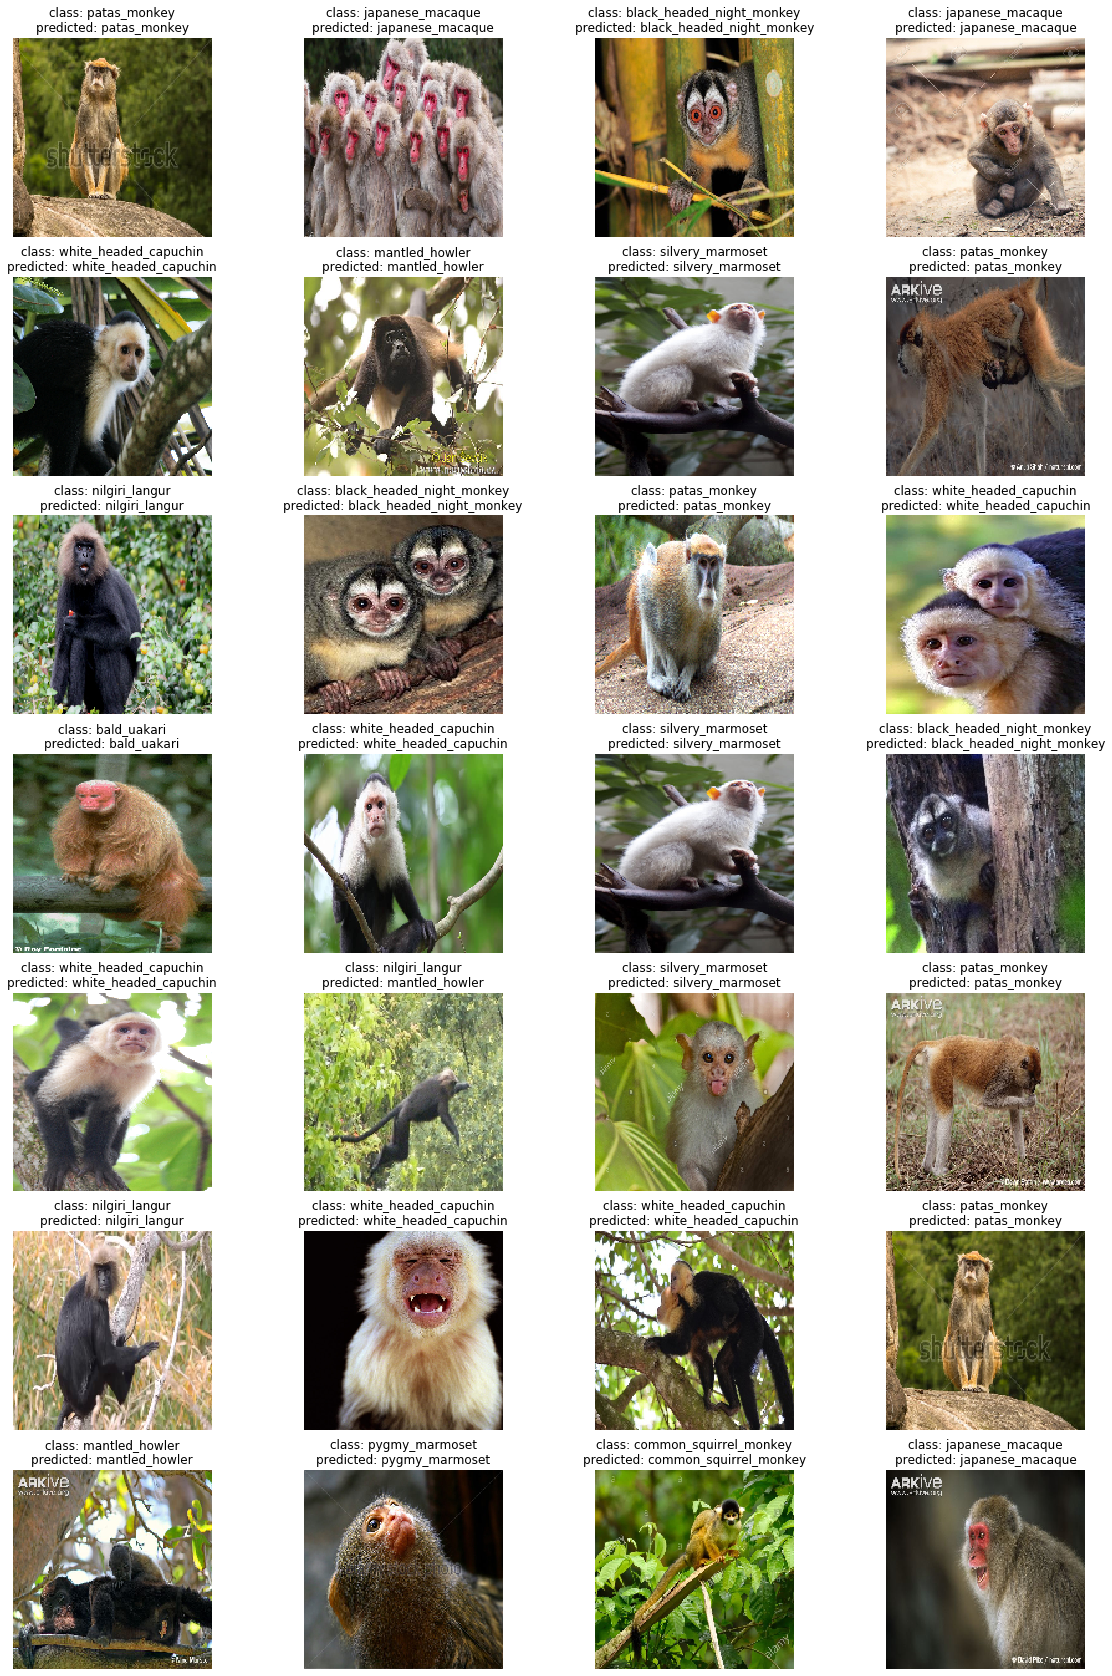

In [18]:
# prediction
plt.figure(figsize=(20,30))
for i, idx in enumerate(random_indices):
    img = np.uint8(x[idx])
    plt.subplot(7,4,i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title("class: " + labels[classes[idx]] + "\npredicted: " + labels[predicted_classes[idx]])
plt.show()